# Поиск неэффективных операторов колл-центров

## Содержание
* [Цель проекта](#purpose)
* [Исходные данные](#data)
* [Предобработка данных](#preprocessing)
* [Исследовательский анализ данных](#analysis)
* [Анализ эффективности операторов поддержки](#in)
* [Итог: функция оценки динамики эффективности оператора поддержки](#in_eff)
* [Анализ эффективности операторов службы обзвона](#out)
* [Итог: функция оценки динамики эффективности оператора обзвона ](#eff_out)
* [Сводная эффективность](#total)
* [Проверка гипотез](#hypothesis)
  * [Гипотеза: время ожидания ответа зависит от тарифного плана](#tariff)
  * [Гипотеза: длительность исходящих звонков зависит от их количества](#size) 
* [Выводы](#conclusions)
* [Презентация](#presentation)
* [](#da) 


## Цель исследования <a id="purpose"></a>
Провайдер IP-телефонии хочет внедрить новый сервис: анализ эффективности операторов колл-центров, которые являются его клиентами.

В своем исследовании мы определим критерии эффективности оператора и предоставим заказчику данные о неэффективных работниках каждого колл-центра.

Если колл-центров с такими сотрудниками окажется много, сервис будет востребован, и наша компания будет предоставлять его функционал по подписке.




In [1]:
#Импортируем необходимые библиотеки
import pandas as pd
import datetime as dt
from scipy import stats as st
from scipy.stats import levene
import numpy as np
import matplotlib.pyplot as plt
#!pip3 install -U seaborn==0.11.1 #без обновления этой библиотеки не строится график sns.displot 
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

## Исходные данные <a id="data"></a>
В нашем распоряжении две таблицы: 
* список колл-центров с указанием тарифного плана и даты начала работы;
* статистика работы колл-центров за несколько месяцев: количество и длительность звонков по каждому оператору, тип звонка (внутренний или внешний, входящий или исходящий)

Изучим данные подробнее.


## Предобработка данных <a id="preprocessing"></a>

In [2]:
from io import BytesIO
import requests
spreadsheet_id = '1PKIHaQV2kjm--EPO9rasdh7r8s6A4I0qxHmf0q7uZhI'
file_name = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(spreadsheet_id)
r = requests.get(file_name)
clients = pd.read_csv(BytesIO(r.content))
clients.info()

#clients = pd.read_csv('https://jupyterhub.praktikum-services.ru/user/user-0-1071367372/edit/telecom_clients.csv')
#clients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user_id      732 non-null    int64 
 1   tariff_plan  732 non-null    object
 2   date_start   732 non-null    object
dtypes: int64(1), object(2)
memory usage: 17.3+ KB


In [3]:
clients.head()

,user_id,tariff_plan,date_start
0,166713,A,2019-08-15
1,166901,A,2019-08-23
2,168527,A,2019-10-29
3,167097,A,2019-09-01
4,168193,A,2019-10-16


In [4]:
clients = clients.astype({'date_start': 'datetime64'})
clients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   user_id      732 non-null    int64         
 1   tariff_plan  732 non-null    object        
 2   date_start   732 non-null    datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 17.3+ KB


In [5]:
print('Клиентов с уникальными идентификаторами в таблице:', clients['user_id'].nunique())

Клиентов с уникальными идентификаторами в таблице: 732


In [6]:
print('Период, в который заключены договоры с провайдером: {:%Y-%m-%d} - {:%Y-%m-%d}.'.format(clients['date_start'].min(), clients['date_start'].max()))

Период, в который заключены договоры с провайдером: 2019-08-01 - 2019-10-31.


In [7]:
print('Уникальные идентификаторы тарифов:', clients['tariff_plan'].unique())

Уникальные идентификаторы тарифов: ['A' 'C' 'B']


В таблице `clients` список из 732 колл-центров, заключивших договор с провайдером в период с 1.08.2019 по 31.10.2019. Услуга тарифицируется тремя различными способами.

Пропусков и дубликатов в таблице нет.

Рассмотрим таблицу с основными данными.

In [8]:
spreadsheet_id = '18BFZhPQzihpSy03keEH3skxMlIoPvZhnqD1HopzREB0'
file_name = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(spreadsheet_id)
r = requests.get(file_name)
data_primary = pd.read_csv(BytesIO(r.content))
data_primary.info()
#data_primary = pd.read_csv('https://jupyterhub.praktikum-services.ru/user/user-0-1071367372/edit/telecom_dataset.csv')
#data_primary.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              53902 non-null  int64  
 1   date                 53902 non-null  object 
 2   direction            53902 non-null  object 
 3   internal             53785 non-null  object 
 4   operator_id          45730 non-null  float64
 5   is_missed_call       53902 non-null  bool   
 6   calls_count          53902 non-null  int64  
 7   call_duration        53902 non-null  int64  
 8   total_call_duration  53902 non-null  int64  
dtypes: bool(1), float64(1), int64(4), object(3)
memory usage: 3.3+ MB


In [9]:
data_primary_len = len(data_primary)
print('Количество строк в исходных данных:', data_primary_len)

Количество строк в исходных данных: 53902


In [10]:
data_primary.head()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,166377,2019-08-04 00:00:00+03:00,in,False,NaN,True,2,0,4
1,166377,2019-08-05 00:00:00+03:00,out,True,880022.0,True,3,0,5
2,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,True,1,0,1
3,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,False,1,10,18
4,166377,2019-08-05 00:00:00+03:00,out,False,880022.0,True,3,0,25


Удалим строки с незаполненной пометкой внутреннего вызова, их около 100 на весь датасет.

In [11]:
data_primary.dropna(subset = ['internal'], inplace = True)

Приведем данные в столбцах к корректным типам.

In [12]:
data = data_primary.astype({'internal': 'bool', 'is_missed_call': 'bool', 'date': 'datetime64', 'user_id': 'object', 'operator_id': 'object'})

In [13]:
#Так как в таблице указано московское время, введем поправку +3 часа 
delta = dt.timedelta(hours=3, minutes=0)
data['date'] = data['date'] + delta

In [14]:
print('Период наблюдений: {:%Y-%m-%d} - {:%Y-%m-%d}'.format(data['date'].min(), data['date'].max()))

Период наблюдений: 2019-08-02 - 2019-11-28


Проверим наличие дубликатов в таблице.

In [15]:
print('Доля дублирующихся строк в общем объёме данных - {:.2%}.'.format(data.duplicated().sum()/len(data)))

Доля дублирующихся строк в общем объёме данных - 9.10%.


Чуть меньше 10% от всего датасета - дублирующиеся строки. Это много. Посмотрим, как они выглядят.

In [16]:
data[data.duplicated(keep = False)].head()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
6,166377,2019-08-05,out,False,880020,True,8,0,50
8,166377,2019-08-05,out,False,880020,True,8,0,50
27,166377,2019-08-12,in,False,NaN,True,2,0,34
28,166377,2019-08-12,in,False,NaN,True,2,0,34
38,166377,2019-08-14,in,False,NaN,True,1,0,3


Похоже, что эти строки действительно нужно удалить, несмотря на то, что они составляют существенную часть датасета.

In [17]:
data = data.drop_duplicates().reset_index(drop = True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48892 entries, 0 to 48891
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   user_id              48892 non-null  object        
 1   date                 48892 non-null  datetime64[ns]
 2   direction            48892 non-null  object        
 3   internal             48892 non-null  bool          
 4   operator_id          41491 non-null  object        
 5   is_missed_call       48892 non-null  bool          
 6   calls_count          48892 non-null  int64         
 7   call_duration        48892 non-null  int64         
 8   total_call_duration  48892 non-null  int64         
dtypes: bool(2), datetime64[ns](1), int64(3), object(3)
memory usage: 2.7+ MB


В столбце `operator_id` больше 7000 пропусков, это 1/7 всего датасета. Удалять такой объем нельзя, заменим пропущенные значения на идентификатор колл-центра + индекс 0. Возможно, позже таких операторов можно будет как-то идентифицировать.

In [18]:
#заменяем пропуски идентификатором клиента с индексом 0
data['operator_id'] = np.where((data.operator_id.isna()), (data.user_id.apply(str) + '_0'), data.operator_id)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48892 entries, 0 to 48891
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   user_id              48892 non-null  object        
 1   date                 48892 non-null  datetime64[ns]
 2   direction            48892 non-null  object        
 3   internal             48892 non-null  bool          
 4   operator_id          48892 non-null  object        
 5   is_missed_call       48892 non-null  bool          
 6   calls_count          48892 non-null  int64         
 7   call_duration        48892 non-null  int64         
 8   total_call_duration  48892 non-null  int64         
dtypes: bool(2), datetime64[ns](1), int64(3), object(3)
memory usage: 2.7+ MB


In [19]:
data['operator_id'].unique()

array(['166377_0', 880022.0, 880020.0, ..., '168603_0', 957922.0,
       '168606_0'], dtype=object)

Проверим, нет ли ошибок в данных - строк, где общая длительность звонка меньше длительности без ожидания.

In [20]:
print('Строки, где общая длительность звонка меньше длительности звонка без ожидания - ', data.query('call_duration > total_call_duration')['call_duration'].count())

Строки, где общая длительность звонка меньше длительности звонка без ожидания -  0


Данные проверены на дубликаты, пропуски, ошибки. Необходимые корректировки произведены. Можно приступать к анализу.

## Исследовательский анализ данных <a id="analysis"></a>

In [21]:
print('Количество клиентов в датасете:', data['user_id'].nunique())

Количество клиентов в датасете: 307


In [22]:
print('Количество операторов в датасете:', data['operator_id'].nunique())

Количество операторов в датасете: 1397


Определим преимущественный вид деятельности каждого колл-центра (работа с входящими или исходящими звонками). В зависимости от этого параметра разработаем критерии эффективности операторов.

In [23]:
data.head()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,166377,2019-08-04,in,False,166377_0,True,2,0,4
1,166377,2019-08-05,out,True,880022,True,3,0,5
2,166377,2019-08-05,out,True,880020,True,1,0,1
3,166377,2019-08-05,out,True,880020,False,1,10,18
4,166377,2019-08-05,out,False,880022,True,3,0,25


Теоретически внутренние звонки (как сервисные) не должны занимать ощутимый объем всех операций. Проверим эту гипотезу.

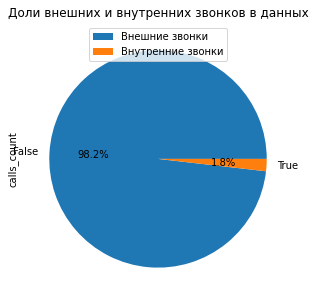

In [24]:
plt.figure(figsize=(5,5))
data.groupby('internal').agg({'calls_count':'sum'})['calls_count'].plot.pie(autopct = '%.1f%%')
plt.title('Доли внешних и внутренних звонков в данных')
labels = ['Внешние звонки', 'Внутренние звонки']
plt.legend(labels, loc = 'upper center')
plt.show()


Гипотеза подтвердилась, количество внутренних (скорее всего, сервисных) звонков составляет меньше 2% от общего объема переговоров.

При определении типа колл-центра их рассматривать не будем.

Присвоим тем колл-центрам, для которых больше 90% объема звонков - входящие, тип "Поддержка". Для тех, у кого больше 90% звонков исходящие - тип "Обзвон". Колл-центрам, у которых нет ярко выраженной специализации - "Смешанный".

In [25]:
#сводная таблица с группировкой по клиентам и разбивкой по направлению связи (внутренние звонки не учитываем)
direction_pivot = data.query('internal == False').pivot_table(index = 'user_id', columns = 'direction', values = 'calls_count', aggfunc = 'sum').reset_index().fillna(0)
direction_pivot.loc[direction_pivot['in'] > direction_pivot['out'] * 10, 'type'] = 'Поддержка' 
direction_pivot.loc[direction_pivot['out'] > direction_pivot['in'] * 10, 'type'] = 'Обзвон'
direction_pivot['type'] = direction_pivot['type'].fillna('Смешанный')
#Сводная таблица с группировкой по типам и количеством клиентов в группе 
type_pivot = direction_pivot.pivot_table(index = 'type', values = 'user_id', aggfunc = 'nunique').sort_values(by = 'user_id', ascending = False)
type_pivot

direction,user_id
type,
Смешанный,162
Поддержка,109
Обзвон,35


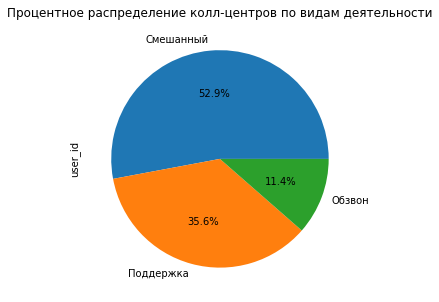

In [26]:
plt.figure(figsize=(5,5))
type_pivot['user_id'].plot.pie(autopct = '%.1f%%')
plt.title('Процентное распределение колл-центров по видам деятельности')
plt.show()


Мы определили специализацию колл-центров и выяснили, что большинство их не имеет четко закрепленного типа деятельности. Значит, подбор параметров для определения эффективности операторов нужно проводить, исходя из типа деятельности самого работника.



Добавим в исходную таблицу столбцы, которые помогут рассчитать нужные критерии:
* Время ожидания ответа
* Специализацию колл-центра
* Период - месяц 

In [27]:
#Время ожидания = Общее время - Время разговора
data['waiting_time'] = data['total_call_duration'] - data['call_duration']

In [28]:
#Добавляем в исходные данные специализацию колл-центра
data = data.merge(direction_pivot, how = 'left').drop(['in', 'out'], axis = 1)
#Прроверка корректности заполнения
#display(data[data['type'].isna()])
#В таблице осталась одна незаполненная строка. Так как анализировать клиента по одной строке нет смысла, удалим ее из датасета.
data.dropna(subset = ['type'], inplace = True)
#Проверка
display(data['type'].unique())
data.head()

array(['Обзвон', 'Поддержка', 'Смешанный'], dtype=object)

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,waiting_time,type
0,166377,2019-08-04,in,False,166377_0,True,2,0,4,4,Обзвон
1,166377,2019-08-05,out,True,880022,True,3,0,5,5,Обзвон
2,166377,2019-08-05,out,True,880020,True,1,0,1,1,Обзвон
3,166377,2019-08-05,out,True,880020,False,1,10,18,8,Обзвон
4,166377,2019-08-05,out,False,880022,True,3,0,25,25,Обзвон


Добавим колонки с месяцем и днем недели.

In [29]:
data['month'] = data['date'].dt.strftime('%m %B')
data['month'].head()

0    08 August
1    08 August
2    08 August
3    08 August
4    08 August
Name: month, dtype: object

In [30]:
data['week'] = data['date'].dt.week
data['week'].head()

0    31
1    32
2    32
3    32
4    32
Name: week, dtype: int64

Для расчетов нам также понадобится количество пропущенных звонков. Выделим их в отдельный столбец.

In [31]:
data.insert(6, "missed_calls_count", 0)
data['missed_calls_count'] = np.where(data['is_missed_call'] == True, data['calls_count'], 0)

Для оператора, работающего на входящих звонках, важны критерии:
* количество пропущенных звонков в день;
* доля пропущенных звонков в общем объёме;
* длительность ожидания ответа оператора. 

Для оператора, работающего на исходящих, можно выделить критерии:
* количество исходящих звонков в день;
* длительность разговора (без учета времени ожидания)



Далее будем рассматривать данные в разрезе специализации операторов.

Начнем с оценки эффективности операторов, работающих на входящих звонках. Посмотрим, как меняется их загрузка во времени.

## Анализ эффективности операторов поддержки <a id="in"></a>

In [32]:
data_in = data.query('direction == "in"')

Для того, чтобы полученные цифры отражали портрет среднего работника, очистим данные от выбросов.

Поскольку для входящих и исходящих звонков время ожидания и количество могут существенно отличаться, аномалии будем отсекать в каждой выборке отдельно.


Рассмотрим столбец времени ожидания.

In [33]:
data_in['waiting_time'].describe()

count    19894.000000
mean       125.423143
std        537.409226
min          0.000000
25%         14.000000
50%         37.000000
75%        102.000000
max      42667.000000
Name: waiting_time, dtype: float64

In [34]:
np.percentile(data_in['waiting_time'], [95, 97.5, 99])

array([ 491.35 ,  828.675, 1375.42 ])

Среднее и медианное время ожидания отличаются почти в 3 раза, стандартное отклонение почти в 4 раза больше среднего. Максимальное время ожидания - 42667 секунды, это 12 часов. 

При этом 95% значений не выходят за рамки "приличного": 492 секунды ожидания - это много, но не запредельно.

Очистим данные от аномальных значений, которые находятся за 95 перцентилем.

In [35]:
percentile_95 = np.percentile(data_in['waiting_time'], 95)
data_in = data_in.query('waiting_time <= @percentile_95')
data_in['waiting_time'].describe()

count    18899.000000
mean        68.871792
std         88.650691
min          0.000000
25%         14.000000
50%         34.000000
75%         85.000000
max        491.000000
Name: waiting_time, dtype: float64

Проверим на аномальные значения и столбец количества звонков.

In [36]:
data_in['calls_count'].describe()

count    18899.000000
mean         5.731838
std         13.090001
min          1.000000
25%          1.000000
50%          2.000000
75%          6.000000
max        714.000000
Name: calls_count, dtype: float64

In [37]:
np.percentile(data_in['calls_count'], [95, 97.5, 99])

array([20., 30., 45.])

Этот параметр также содержит аномальные значения, искажающие средние показатели. Отсечём их на уровне 95-го перцентиля.

In [38]:
percentile_95_calls = np.percentile(data_in['calls_count'], 95)
data_in = data_in.query('calls_count <= @percentile_95_calls')
data_in['calls_count'].describe()

count    17961.000000
mean         3.877958
std          3.979629
min          1.000000
25%          1.000000
50%          2.000000
75%          5.000000
max         20.000000
Name: calls_count, dtype: float64

Сравним данные по абсолютному количеству пропущенных с их долей в общем количестве звонков. Посмотрим на их динамику во времени и сравним с динамикой количества операторов/колл-центров.

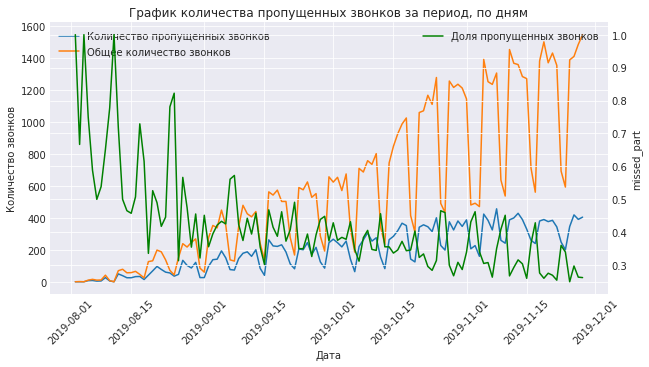

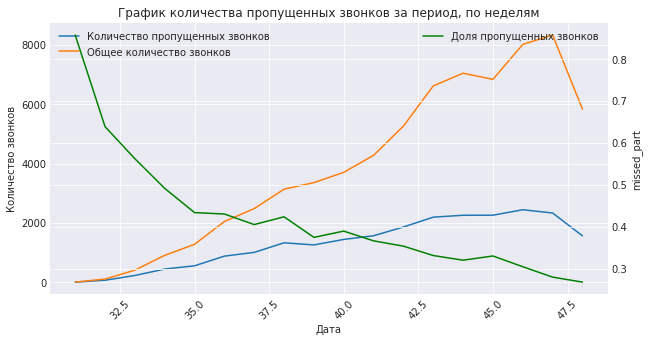

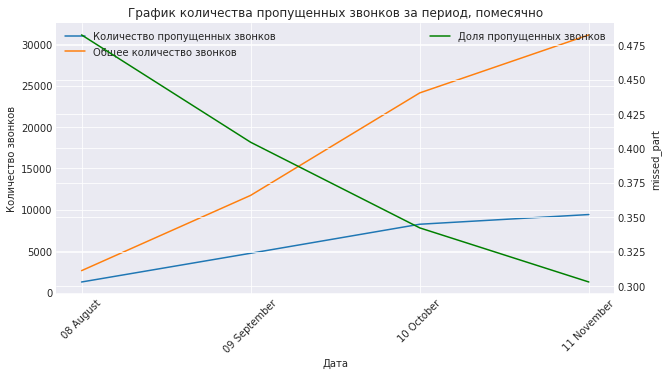

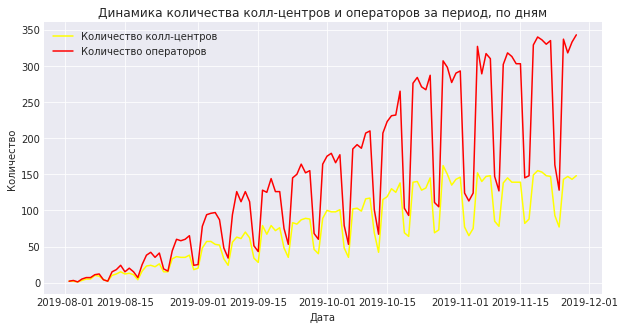

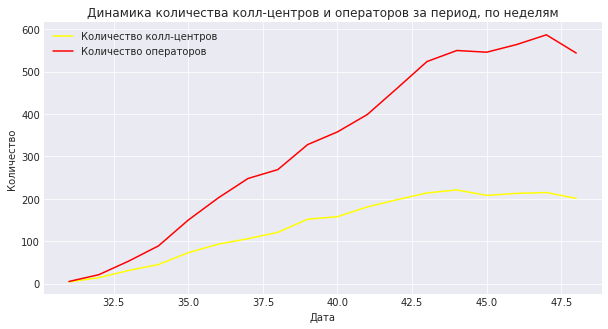

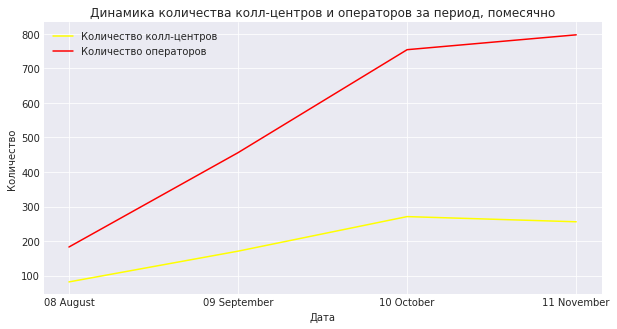

In [39]:
date_dict = {'date':'по дням', 'week': 'по неделям', 'month':'помесячно'}
legend = ['Количество пропущенных звонков','Общее количество звонков']
legend2 = ['Доля пропущенных звонков']
legend3 = ['Количество колл-центров', 'Количество операторов']
for i, j in date_dict.items():
  with plt.style.context('seaborn-darkgrid'):
    fig, ax = plt.subplots(figsize=(10,5))
    #сводная таблица по датам/месяцу со значениями количества звонков (принятых и пропущенных)
    missed_call_part_pivot = (data_in.pivot_table(index = i, columns = 'is_missed_call', 
                                               values = 'calls_count', aggfunc = 'sum').
                                               fillna(0).reset_index())
    #столбец суммарного количества звонков
    missed_call_part_pivot['sum_calls'] = missed_call_part_pivot[True] + missed_call_part_pivot[False]
    #доля пропущенных звонков в общем количестве
    missed_call_part_pivot['missed_part'] = missed_call_part_pivot[True]/missed_call_part_pivot['sum_calls']
    ax = sns.lineplot(data = missed_call_part_pivot, x = i, y = True, ax = ax)
    ax = sns.lineplot(data = missed_call_part_pivot, x = i, y = 'sum_calls', ax = ax)
    plt.legend(legend)
    plt.title('График количества пропущенных звонков за период, {}'.format(j))
    plt.xlabel('Дата')
    plt.ylabel('Количество звонков')
    plt.xticks(rotation=45)
    ax2 = ax.twinx()
    ax2 = sns.lineplot(data = missed_call_part_pivot, x = i, y = 'missed_part', ax = ax2, color = 'green')
    plt.legend(legend2)
    
#Дополнительный график по динамике роста числа колл-центров и операторов
for i, j in date_dict.items():
  with plt.style.context('seaborn-darkgrid'):
    fig, ax = plt.subplots(figsize=(10,5))
    operator_user_pivot = (data_in.pivot_table(index = i, 
                                            values = ['user_id', 'operator_id'], aggfunc = pd.Series.nunique).reset_index())
    ax = sns.lineplot(data = operator_user_pivot, x = i, y = 'user_id', ax = ax, color = 'yellow')
    ax = sns.lineplot(data = operator_user_pivot, x = i, y = 'operator_id', ax = ax, color = 'red')
    plt.title('Динамика количества колл-центров и операторов за период, {}'.format(j))
    plt.xlabel('Дата')
    plt.ylabel('Количество')
    plt.legend(legend3)

В нашем распоряжении данные за относительно небольшой период, с одной стороны, и без детализации по времени, с другой. Нет возможности утверждать о какой-либо сезонности. Видны особенности:
* Количество звонков интенсивно растет от августа к ноябрю (отдельно нужно обратить внимание на падение в последнюю неделю рассматриваемого периода);
* Четко видна цикличность работы колл-центров: в выходные количество звонков снижается в разы;
* Доля пропущенных звонков снижается с течением времени (и увеличением объема звонков), но остается на высоком уровне около 30%.


Набор графиков для количества операторов/клиентов дополняет картину:

* Некоторые клиенты не работают в выходные. Тенденция к провалу графиков в сб-вс видна и на этом графике.
* Наша компания привлекает новых клиентов. В период август-октябрь идет рост и количества клиентов, и их операторов.
* С октября тенденция немного меняется - количество клиентов незначительно снижается, а число операторов продолжает расти. Это означает, что клиентская база меняется в сторону средних и крупных колл-центров. 

Если бы данные содержали точную информацию по времени каждого звонка, мы могли бы оценить пиковую суточную нагрузку.

Самым информативным кажется график понедельной динамики показателей. Такую детализацию и возьмем за основу в дальнейшем анализе.


Построим распределения параметров эффективности на агрегированных по неделям данных и сравним их со среднемесячными.

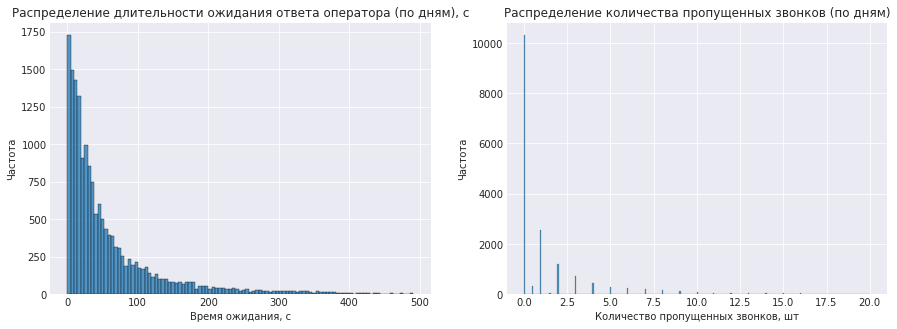

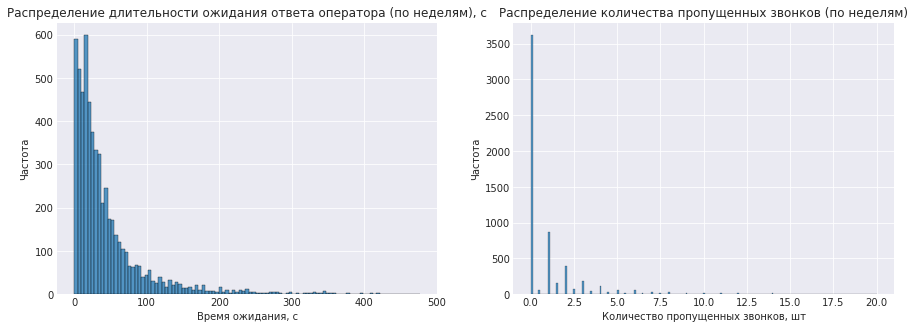

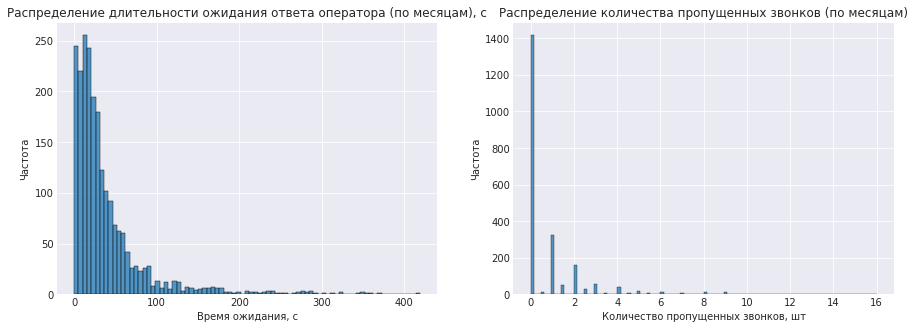

In [40]:
period = {'date':'по дням', 'week': 'по неделям', 'month':'по месяцам'}
for i,j in period.items():
    data_period_median = data_in.groupby([i, 'operator_id']).agg({'missed_calls_count':'median', 'waiting_time':'median'}).reset_index()
    with plt.style.context('seaborn-darkgrid'):
      plt.figure(figsize=(15,5))
      ax1 = plt.subplot(1,2,1)
      #Поскольку нас интересует длительность ожидания ответа, исключаем из данных нулевые значения
      ax1 = sns.histplot(data = data_period_median, x = 'waiting_time')
      plt.title('Распределение длительности ожидания ответа оператора ({}), с'.format(j))
      plt.xlabel('Время ожидания, с')
      plt.ylabel('Частота')
      ax2 = plt.subplot(1,2,2)
      #Берем статистику только по пропущенным звонкам
      ax2 = sns.histplot(data = data_period_median, x = 'missed_calls_count')
      plt.title('Распределение количества пропущенных звонков ({})'.format(j))
      plt.xlabel('Количество пропущенных звонков, шт')
      plt.ylabel('Частота')

Оба распределения имеют экспоненциальный вид, хвост их сильно смещен в сторону больших значений. В этом случае для выбора порогового значения эффективности следует взять наиболее часто встречающиеся значения (моду).

Данные по дням слишком шумные, их сложно использовать для адекватной оценки. Идеально использовать данные за неделю, они учитывают колебания нагрузки по будням/выходным. Но отчетный период в большинстве компаний - месяц. Привяжем оценку эффективности к месяцу.

Посмотрим на средние показатели времени ожидания в таблице:

In [41]:
res = []
for i in data_in['month'].unique():
    data_month_median = data_in.query('month == @i').groupby(['operator_id']).agg({'missed_calls_count':'median', 'waiting_time':'median'}).reset_index()
    res += ([[i, 'waiting_time', data_month_median['waiting_time'].mode()[0], 
                data_month_median['waiting_time'].median(),
                 data_month_median['waiting_time'].mean()]])
res = pd.DataFrame(res, columns = ['month', 'metrics', 'mode', 'median', 'mean'])

In [42]:
res.head()

,month,metrics,mode,median,mean
0,08 August,waiting_time,2.0,20.0,31.377049
1,09 September,waiting_time,2.0,24.0,36.746711
2,10 October,waiting_time,2.0,21.0,36.740716
3,11 November,waiting_time,26.0,26.0,43.146173


Построим таблицу со средними долями пропущенных звонков по месяцу:

In [43]:
missed_call_part_pivot = (data_in.pivot_table(index = 'month', columns = 'is_missed_call', 
                                               values = 'calls_count', aggfunc = 'sum').
                                               fillna(0).reset_index())
#столбец суммарного количества звонков
missed_call_part_pivot['sum_calls'] = missed_call_part_pivot[True] + missed_call_part_pivot[False]
#доля пропущенных звонков в общем количестве
missed_call_part_pivot['missed_part'] = missed_call_part_pivot[True]/missed_call_part_pivot['sum_calls']
missed_call_part = missed_call_part_pivot[['month', 'missed_part']]
missed_call_part.insert(1, "metrics", 'part_missed_calls')
missed_call_part['min'] = missed_call_part['missed_part'].min()
missed_call_part['max'] = missed_call_part['missed_part'].max()
missed_call_part

is_missed_call,month,metrics,missed_part,min,max
0,08 August,part_missed_calls,0.482628,0.30283,0.482628
1,09 September,part_missed_calls,0.404513,0.30283,0.482628
2,10 October,part_missed_calls,0.342203,0.30283,0.482628
3,11 November,part_missed_calls,0.302830,0.30283,0.482628


Логично группировать операторов по нескольким уровням эффективности. Первый показатель - время ожидания ответа оператора. Второй - количество пропущенных звонков. Так как количество звонков сильно отличается для каждого оператора, введем относительный показатель - долю пропущенных. Их не должно быть более 30% (минимальная средняя доля пропущенных в месяц) для эффективной работы. Если их больше 50% (максимальная средняя доля пропущенных в месяц) - работу признаём не эффективной.

**Для операторов поддержки комплексный показатель будет таким:**

* **время ожидания не больше ежемесячной моды и доля пропущенных не более минимальной по месяцу - идеальный случай;**
* **интервал между модой и медианой соответствующих показателей и разница между минимумом и максимумом пропущенных по месяцу - допустимая эффективность;**
* **больше медианного времени ожидания и больше месячного максимума пропущенных звонков в месяц - неэффективная работа.**



Создаем массив метрик эффективности по каждому оператору помесячно. При усреднении используем **медианные значения** из-за наличия выбросов в данных.

In [44]:
#Создаем пустой список для загрузки результатов расчетов
#results = []
#в цикле проходим фильтром по каждому номеру оператора и считаем медианную длительность разговора по месяцу
#for j in data_in['month'].unique():
#    for i in data_in['operator_id'].unique():
#      results += [[i, j, 'waiting_time', data_in.query('month == @j').query('operator_id == @i')['waiting_time'].median()]]
#преобразуем список в датафрейм
#results = pd.DataFrame(results, columns = ['operator_id', 'month', 'metrics', 'value'])
results = data_in.groupby(['operator_id','month']).agg({'waiting_time' : 'median'}).reset_index()
results.insert(2, 'metrics', 'waiting_time')
results.rename(columns={'waiting_time': 'value'}, inplace=True)

Медианные значения длительности разговора по каждому оператору за месяц:

In [45]:
results.head()

,operator_id,month,metrics,value
0,879896,08 August,waiting_time,17.0
1,879896,09 September,waiting_time,11.0
2,879896,10 October,waiting_time,20.5
3,879898,08 August,waiting_time,15.0
4,879898,09 September,waiting_time,13.0


Считаем долю пропущенных за месяц звонков по каждому оператору.

In [46]:
#Для расчета средней по месяцу доли пропущенных звонков по каждому оператору строим сводную таблицу
av_part_missed_calls_pivot = (data_in.
                pivot_table(index = ['operator_id','month'], columns = 'is_missed_call', 
                              values = 'calls_count', aggfunc = 'sum').fillna(0)).reset_index()
#Добавляем в таблицу столбец суммарного количества звонков
av_part_missed_calls_pivot['sum_calls'] = av_part_missed_calls_pivot[True] + av_part_missed_calls_pivot[False]
#Столбец с долей пропущенных
av_part_missed_calls_pivot['part_missed_calls'] = av_part_missed_calls_pivot[True] / av_part_missed_calls_pivot['sum_calls']

In [47]:
#Корректируем таблицу для корректного слияния с таблицей показателей эффективности
av_part_missed_calls = av_part_missed_calls_pivot[['operator_id', 'month', 'part_missed_calls']]
av_part_missed_calls = av_part_missed_calls.rename(columns={'part_missed_calls': 'value'})
av_part_missed_calls.insert(2, "metrics", 'part_missed_calls')
av_part_missed_calls.head()

is_missed_call,operator_id,month,metrics,value
0,879896,08 August,part_missed_calls,0.0
1,879896,09 September,part_missed_calls,0.0
2,879896,10 October,part_missed_calls,0.0
3,879898,08 August,part_missed_calls,0.0
4,879898,09 September,part_missed_calls,0.0


Получили два списка со значениями метрик эффективности входящих звонков. Соединяем их в одну таблицу.

In [48]:
#добавляем в таблицу эффективности среднюю долю пропущенных
eff_metrics_in = pd.concat([results, av_part_missed_calls], ignore_index=True)

In [49]:
eff_metrics_in.sample(3)

is_missed_call,operator_id,month,metrics,value
1029,932836,10 October,waiting_time,20.500000
2864,911140,11 November,part_missed_calls,0.026316
3344,937958,11 November,part_missed_calls,0.009259


Добавляем в таблицу пороговые значения эффективности для каждого месяца (они были рассчитаны ранее).

In [50]:
eff_metrics_in = eff_metrics_in.merge(res, on = ['month', 'metrics'], how = 'outer')

In [51]:
eff_metrics_in = eff_metrics_in.merge(missed_call_part, on = ['month', 'metrics'], how = 'outer')

In [52]:
eff_metrics_in = eff_metrics_in.drop('missed_part', axis = 1)

Важный шаг: поскольку в строках появились пропуски из-за того, что некоторые операторы не работали в определенные месяцы, их нужно удалить для корректной оценки эффективности.

In [53]:
eff_metrics_in = eff_metrics_in.dropna(subset = ['value'])

In [54]:
eff_metrics_in.head(5)

,operator_id,month,metrics,value,mode,median,mean,min,max
0,879896,08 August,waiting_time,17.0,2.0,20.0,31.377049,NaN,NaN
1,879898,08 August,waiting_time,15.0,2.0,20.0,31.377049,NaN,NaN
2,880020,08 August,waiting_time,16.0,2.0,20.0,31.377049,NaN,NaN
3,880026,08 August,waiting_time,7.0,2.0,20.0,31.377049,NaN,NaN
4,880028,08 August,waiting_time,13.0,2.0,20.0,31.377049,NaN,NaN


Таблица содержит показатели деятельности каждого оператора и отобранные нами средние показатели в разрезе месяца. Присвоим  операторам ранг по каждой метрике:
* 0 - низкая эффективность
* 1 - средняя эффективность
* 2 - высокая эффективность

In [55]:
def eff_group(metrics, value, median, mode, max, min):
    if metrics == 'waiting_time':
        if value > median:
            return "0"
        elif value <= mode:
            return "2"
        else: 
            return "1"
    else:
        if value > max:
            return "0"
        elif value < min:
            return "2"
        else:
            return "1"

eff_metrics_in['eff_group'] = eff_metrics_in.apply(lambda x: eff_group(x.metrics, x.value, x['median'], x['mode'], x['max'], x['min']), axis = 1) 
eff_metrics_in.sample(5)

,operator_id,month,metrics,value,mode,median,mean,min,max,eff_group
316,903312,09 September,waiting_time,48.0,2.0,24.0,36.746711,NaN,NaN,0
3882,934608,11 November,part_missed_calls,0.0,NaN,NaN,NaN,0.30283,0.482628,2
731,900788,10 October,waiting_time,17.0,2.0,21.0,36.740716,NaN,NaN,1
1513,906408,11 November,waiting_time,83.0,26.0,26.0,43.146173,NaN,NaN,0
1392,168575_0,10 October,waiting_time,2.0,2.0,21.0,36.740716,NaN,NaN,2


In [56]:
print('Распределение показателей эффективности по количеству пропущенных')
display(eff_metrics_in.query('metrics == "part_missed_calls"')['eff_group'].value_counts())
print('Распределение показателей эффективности по времени ожидания ответа')
display(eff_metrics_in.query('metrics == "waiting_time"')['eff_group'].value_counts())

Распределение показателей эффективности по количеству пропущенных


2    1421
0     762
1       7
Name: eff_group, dtype: int64

Распределение показателей эффективности по времени ожидания ответа


0    1076
1     618
2     496
Name: eff_group, dtype: int64

**Наиболее жёстким критерием ожидаемо оказался параметр среднего ожидания ответа оператора**. По нему чуть меньше половины операторов не эффективны (порог эффективности - медианное значение). 

Итоговая эффективность - минимум из двух параметров, достигнутый каждым сотрудником. **Низкоэффективной работой считаем ту, где хотя бы один параметр равен нулю.** 

In [57]:
eff_metrics_in['eff_group'] = eff_metrics_in['eff_group'].astype(int)
eff_metrics_in_final = eff_metrics_in.pivot_table(index = ['operator_id', 'month'], columns = 'metrics', values = 'eff_group').reset_index()
eff_metrics_in_final['eff_group_total'] = np.where(eff_metrics_in_final['part_missed_calls'] <= eff_metrics_in_final['waiting_time'], eff_metrics_in_final['part_missed_calls'], eff_metrics_in_final['waiting_time'])
eff_metrics_in_final.rename(columns={'part_missed_calls': 'part_missed_calls_rank', 'waiting_time':'waiting_time_rank' }, inplace=True)
eff_metrics_in_final.sample(5)

metrics,operator_id,month,part_missed_calls_rank,waiting_time_rank,eff_group_total
1369,952916,11 November,2,2,2
992,930510,11 November,2,0,0
1141,937868,10 October,2,0,0
232,895170,09 September,2,1,1
858,921306,10 October,2,0,0


In [58]:
eff_metrics_in_final.sample(3)

metrics,operator_id,month,part_missed_calls_rank,waiting_time_rank,eff_group_total
342,900194,10 October,2,0,0
1390,956480,11 November,2,0,0
297,896708,08 August,2,0,0


Итак, каждому оператору присвоен ранг эффективности. Пропорционально группы распределились следующим образом:

In [59]:
eff_pivot_in = eff_metrics_in_final.pivot_table(index = ['month','eff_group_total'], values = 'operator_id', aggfunc = pd.Series.nunique).reset_index()
display(eff_pivot_in)

metrics,month,eff_group_total,operator_id
0,08 August,0,136
1,08 August,1,47
2,09 September,0,318
3,09 September,1,136
4,09 September,2,2
5,10 October,0,532
6,10 October,1,218
7,10 October,2,4
8,11 November,0,509
9,11 November,1,2


Покажем эти данные на графике:

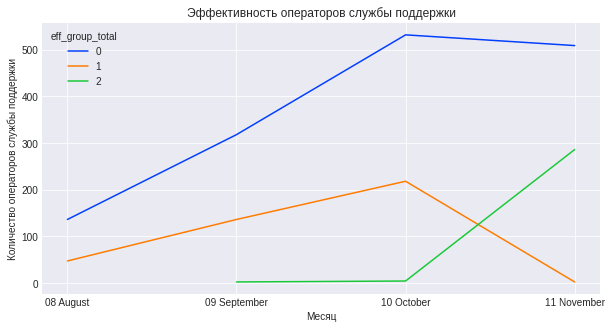

In [60]:
with plt.style.context('seaborn-darkgrid'):
    plt.figure(figsize=(10,5))
    ax = sns.lineplot(data = eff_pivot_in, hue = 'eff_group_total', y = 'operator_id', x = 'month', palette='bright')
    plt.title('Эффективность операторов службы поддержки')
    plt.xlabel('Месяц')
    plt.ylabel('Количество операторов службы поддержки')
    plt.show()

In [61]:
user_pivot_in = data_in.pivot_table(index = ['operator_id', 'user_id'], values = 'date', aggfunc = 'count').reset_index()

In [62]:
eff_metrics_in_final = eff_metrics_in_final.merge(user_pivot_in[['user_id', 'operator_id']], on = 'operator_id', how = 'left')

In [63]:
eff_metrics_in_final.head()

,operator_id,month,part_missed_calls_rank,waiting_time_rank,eff_group_total,user_id
0,879896,08 August,2,1,1,166406
1,879896,09 September,2,1,1,166406
2,879896,10 October,2,1,1,166406
3,879898,08 August,2,1,1,166406
4,879898,09 September,2,1,1,166406


## Итог: функция оценки динамики эффективности оператора поддержки  <a id="in_eff"></a>

Напишем функцию для фильтрации колл-центра/номера оператора и просмотра эффективности их работы в динамике.

In [64]:
''' Функции на вход дается датасет с посчитанной эффективностью, 
а также номер колл-центра и номер оператора, которого нужно отследить. 
Если номер колл-центра не указан (на вход подается 0), выводятся данные по всем колл-центрам.
Если не указан номер оператора - по всем операторам'''
def user_eff(data, user_id, operator_id):
    if user_id == 0 and operator_id == 0:
        return data
    elif user_id == 0 and operator_id != 0:
        return data.query('operator_id == @operator_id')
    elif user_id != 0 and operator_id == 0:
        return data.query('user_id == @user_id')
    else:
        return data.query('user_id == @user_id and operator_id == @operator_id')
user_eff(eff_metrics_in_final, 166406, 0)

,operator_id,month,part_missed_calls_rank,waiting_time_rank,eff_group_total,user_id
0,879896,08 August,2,1,1,166406
1,879896,09 September,2,1,1,166406
2,879896,10 October,2,1,1,166406
3,879898,08 August,2,1,1,166406
4,879898,09 September,2,1,1,166406
5,879898,10 October,2,1,1,166406
6,879898,11 November,2,2,2,166406
1468,166406_0,08 August,0,0,0,166406
1469,166406_0,09 September,0,0,0,166406
1470,166406_0,10 October,0,0,0,166406


Добавляем визуализацию на основе отфильтрованных данных. В качестве примера берем всех операторов колл-центра №166406.

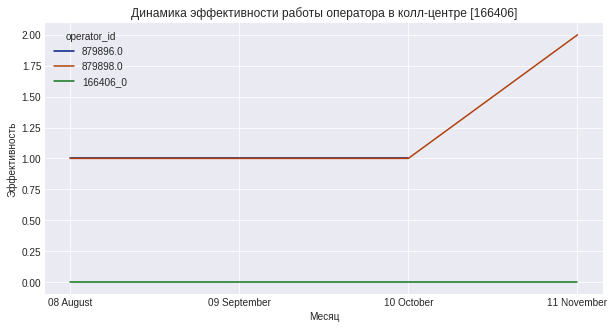

In [65]:
with plt.style.context('seaborn-darkgrid'):
    plt.figure(figsize=(10,5))
    sns.lineplot(data = user_eff(eff_metrics_in_final, 166406, 0), x = 'month', y = 'eff_group_total', hue = 'operator_id', palette='dark')
    plt.title('Динамика эффективности работы оператора в колл-центре {}'.format(user_eff(eff_metrics_in_final, 166406, 0)['user_id'].unique()))
    plt.xlabel('Месяц')
    plt.ylabel('Эффективность')
    plt.show()

Добавим столбец с категориями эффективности в основную таблицу операторов поддержки.

In [66]:
data_in = data_in.merge(eff_metrics_in_final[['operator_id', 'month', 'eff_group_total']], on = ['month', 'operator_id'], how = 'left')
#Проверка, что все операторы получили свой "грейд"
data_in['eff_group_total'].unique()

array([0, 1, 2])

## Анализ эффективности операторов службы обзвона <a id="out"></a>

Разберемся с эффективностью операторов другой специализации.

Выше мы выделили следующие критерии для этой группы:

* количество исходящих звонков в день;
* длительность разговора (без учета времени ожидания)

Выделим сотрудников обзвона из общей базы и проверим нужные нам данные на предмет аномалий.

In [67]:
data_out = data.query('direction == "out"')
data_out.head()

,user_id,date,direction,internal,operator_id,is_missed_call,missed_calls_count,calls_count,call_duration,total_call_duration,waiting_time,type,month,week
1,166377,2019-08-05,out,True,880022,True,3,3,0,5,5,Обзвон,08 August,32
2,166377,2019-08-05,out,True,880020,True,1,1,0,1,1,Обзвон,08 August,32
3,166377,2019-08-05,out,True,880020,False,0,1,10,18,8,Обзвон,08 August,32
4,166377,2019-08-05,out,False,880022,True,3,3,0,25,25,Обзвон,08 August,32
5,166377,2019-08-05,out,False,880020,False,0,2,3,29,26,Обзвон,08 August,32


Проверим на аномалии столбец длительности переговоров. 

In [68]:
data_out['call_duration'].describe()

count     28997.000000
mean       1124.381764
std        4766.463206
min           0.000000
25%           0.000000
50%          21.000000
75%         718.000000
max      144395.000000
Name: call_duration, dtype: float64

In [69]:
np.percentile(data_out['call_duration'], [95, 97.5, 99])

array([ 4846.2 ,  7794.2 , 12907.16])

95% переговоров длятся не больше 4846 секунд (80 минут). Значения выше этого порога уберем, чтобы сократить разброс в данных (на данный момент стандартное отклонение в 3 раза больше среднего, а среднее и медиана отличаются в 50 раз!).

In [70]:
perc_calls_out_95 = np.percentile(data_out['call_duration'], 95)
data_out = data_out.query('call_duration < @perc_calls_out_95')
data_out['call_duration'].describe()

count    27547.000000
mean       493.181907
std        938.643244
min          0.000000
25%          0.000000
50%          6.000000
75%        517.000000
max       4846.000000
Name: call_duration, dtype: float64

In [71]:
data_out['calls_count'].describe()

count    27547.000000
mean        15.813991
std         55.472937
min          1.000000
25%          2.000000
50%          5.000000
75%         15.000000
max       4817.000000
Name: calls_count, dtype: float64

In [72]:
np.percentile(data_out['calls_count'], [95, 97.5, 99])

array([ 57.,  81., 139.])

При максимальном количестве звонков 4817 средняя на уровне 15. Аномальные значения свыше 95 перцентиля тоже необходимо удалить.

In [73]:
perc_count_out_95 = np.percentile(data_out['calls_count'], 95)
data_out = data_out.query('calls_count < @perc_count_out_95')
data_out['calls_count'].describe()

count    26141.000000
mean         9.378907
std         11.680770
min          1.000000
25%          2.000000
50%          4.000000
75%         12.000000
max         56.000000
Name: calls_count, dtype: float64

Построим графики динамики количества звонков и их длительности в зависимости от времени. 

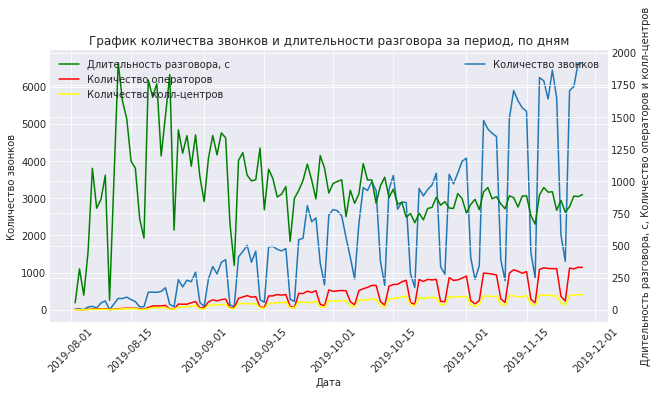

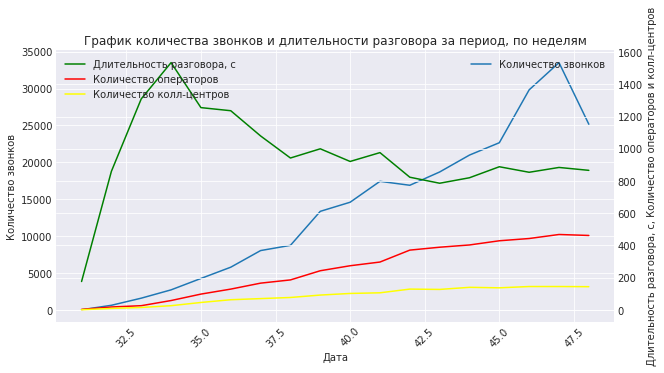

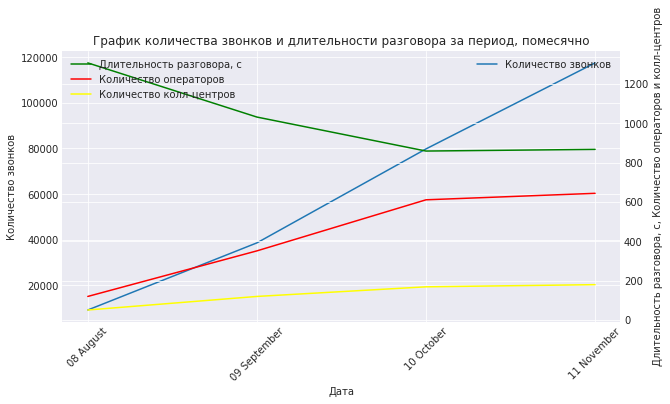

In [74]:
date_dict = {'date':'по дням', 'week': 'по неделям', 'month':'помесячно'}
legend = ['Количество звонков']
legend2 = ['Длительность разговора, с', 'Количество операторов', 'Количество колл-центров']
for i, j in date_dict.items():
  with plt.style.context('seaborn-darkgrid'):
    fig, ax = plt.subplots(figsize=(10,5))
    #сводная таблица по датам/месяцу со значениями количества исходящих звонков 
    calls_count_pivot_sum = data_out.pivot_table(index = i, values = 'calls_count', aggfunc = 'sum').reset_index()
    ax = sns.lineplot(data = calls_count_pivot_sum, x = i, y = 'calls_count', ax = ax)
    plt.legend(legend, loc = 'upper right')
    plt.title('График количества звонков и длительности разговора за период, {}'.format(j))
    plt.xlabel('Дата')
    plt.ylabel('Количество звонков')
    plt.xticks(rotation=45)
    ax2 = ax.twinx()
    #Сводная таблица по средней длительности переговоров. Несостоявшиеся переговоры (с нулевой длительностью) в этом параметре учитывать не будем.
    call_duration_pivot = data_out.query('call_duration != 0').pivot_table(index = i, values = 'call_duration', aggfunc = 'mean').reset_index()
    ax2 = sns.lineplot(data = call_duration_pivot, x = i, y = 'call_duration', ax = ax2, color = 'green')
    #Сводная по количеству операторов
    operator_count_pivot = data_out.pivot_table(index = i, values = 'operator_id', aggfunc = pd.Series.nunique).reset_index()
    user_count_pivot = data_out.pivot_table(index = i, values = 'user_id', aggfunc = pd.Series.nunique).reset_index()
    ax2 = sns.lineplot(data = operator_count_pivot, x = i, y = 'operator_id', ax = ax2, color = 'red')
    ax2 = sns.lineplot(data = user_count_pivot, x = i, y = 'user_id', ax = ax2, color = 'yellow')
    plt.ylabel('Длительность разговора, с, Количество операторов и колл-центров')
    plt.legend(legend2, loc = 'upper left')

По операторам обзвона наблюдаем картину, схожую с картиной по операторам поддержки:
* Количество звонков циклично меняется, в выходные нагрузка падает в разы;
* По выходным работает меньше операторов;
* В наблюдаемый период привлекаются новые клиенты - растет и количество колл-центров, и операторов. Похоже, прирост числа операторов происходит именно из-за расширения клиентской базы, а не из-за набора новых сотрудников. Линии на графике имеют схожие тенденции, то есть среднее количество сотрудников на колл-центр остается примерно одинаковым;
* Средняя длительность разговора снижается на протяжении рассматриваемого периода. Скорее всего, это связано с нерепрезентативностью данных за первый месяц, их слишком мало, велик разброс. В октябре-ноябре данные стабилизируются, длительность звонков тоже.




Проверим распределения параметров оценки эффективности, хотя они, скорее всего, будут такими же, как и параметры группы поддержки.

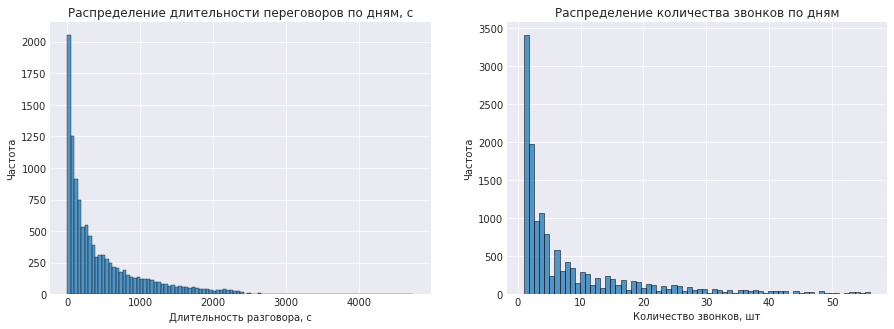

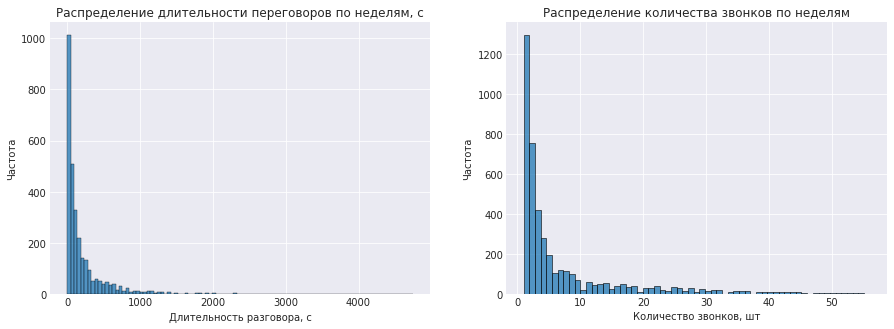

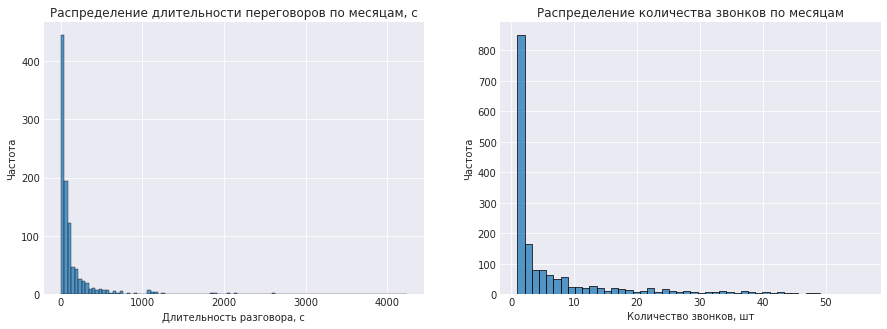

In [75]:
period = {'date':'по дням', 'week': 'по неделям', 'month':'по месяцам'}
for i,j in period.items():
    data_period_median_out = data_out.groupby([i, 'operator_id']).agg({'call_duration':'median', 'calls_count':'median'}).reset_index()
    with plt.style.context('seaborn-darkgrid'):
      plt.figure(figsize=(15,5))
      ax1 = plt.subplot(1,2,1)
      ax1 = sns.histplot(data = data_period_median_out.query('call_duration != 0'), x = 'call_duration', bins = 100)
      plt.title('Распределение длительности переговоров {}, с'.format(j))
      plt.xlabel('Длительность разговора, с')
      plt.ylabel('Частота')
      ax2 = plt.subplot(1,2,2)
      ax2 = sns.histplot(data = data_period_median_out, x = 'calls_count')
      plt.title('Распределение количества звонков {}'.format(j))
      plt.xlabel('Количество звонков, шт')
      plt.ylabel('Частота')

Распределения в любой агрегации имеют экспоненциальный характер. Большая часть звонков в имеющемся датасете имеет короткую длительность.

Настораживает распределение количества звонков. Операторы обзвона должны совершать довольно много переговоров в течение дня, но большинство этого не делает.

**Средняя длительность разговора сильно меняется в зависимости от колл-центра**. Это может быть связано со спецификой разговора: информационное сообщение, предложение услуг или опросник. Однако в такой небольшой по времени выборке не удалось найти взаимосвязь между длительностью переговоров и средним ежедневным количеством звонков, поэтому оценивать эффективность операторов обзвона будем без группировки колл-центров по специфике. Для оценки этого параметра сделаем дашборд с интерактивной статистикой.


Как и в случае с оценкой операторов поддержки, будем рассматривать показатели эффективности за месяц. Соберем в одну таблицу средние значения интересующих нас параметров. Звонки нулевой длительности для опрееления средних рассматривать не будем.

In [76]:
res_out = []
for i in data_out['month'].unique():
    data_out_month_median = data_out.query('month == @i').groupby(['operator_id']).agg({'calls_count':'median', 'call_duration':'median'}).reset_index()
    res_out += ([[i, 'calls_count', data_out_month_median['calls_count'].mode()[0], 
                data_out_month_median['calls_count'].median(),
                 data_out_month_median['calls_count'].mean()]])
    res_out += ([[i, 'call_duration', data_out_month_median.query('call_duration != 0')['call_duration'].mode()[0], 
                data_out_month_median.query('call_duration != 0')['call_duration'].median(),
                 data_out_month_median.query('call_duration != 0')['call_duration'].mean()]])
res_out = pd.DataFrame(res_out, columns = ['month', 'metrics', 'mode', 'median', 'mean'])
res_out

,month,metrics,mode,median,mean
0,08 August,calls_count,1.0,3.0,5.504202
1,08 August,call_duration,3.0,65.0,217.225806
2,09 September,calls_count,1.0,2.5,7.947293
3,09 September,call_duration,5.0,72.5,273.047739
4,10 October,calls_count,1.0,2.0,7.682488
5,10 October,call_duration,7.0,49.0,169.320513
6,11 November,calls_count,1.0,2.5,6.979037
7,11 November,call_duration,7.0,50.5,125.714953


Не зная целевую длительность звонков колл-центров разной специфики, мы не можем оценить степени эффективности. Если понадобится конкретизация, нужно будет запрашивать новые данные.

Выделим однозначно неэффективных операторов:
* Низкая эффективность, если длительность звонка и количество звонков меньше или равны моде;
* Высокая эффективность, если количество звонков больше среднего, а длительность разговора находится между модой и медианой;
* Средняя эффективность - все остальные случаи. Сюда попадут и слишком короткие переговоры, и слишком длинные, и количество звонков меньше среднего.

Строим таблицу сводных показателей эффективности по операторам обзвона.

In [77]:
call_duration_out = data_out.pivot_table(index = ['operator_id', 'month'], values = 'call_duration', aggfunc = 'median').reset_index()
call_duration_out.insert(2, "metrics", 'call_duration')
call_duration_out.rename(columns = {'call_duration':'value'}, inplace = True)
calls_count_out = data_out.pivot_table(index = ['operator_id', 'month'], values = 'calls_count', aggfunc = 'median').reset_index()
calls_count_out.insert(2, "metrics", 'calls_count')
calls_count_out.rename(columns = {'calls_count':'value'}, inplace = True)
eff_metrics_out = pd.concat([call_duration_out, calls_count_out])
eff_metrics_out.columns = ['operator_id', 'month', 'metrics','value']
eff_metrics_out.sample(3)

,operator_id,month,metrics,value
1051,928228,10 October,calls_count,12.5
1251,937980,11 November,calls_count,4.0
1621,965232,11 November,calls_count,1.5


Добавим к таблице показателей рассчитанные нами средние.

In [78]:
eff_metrics_out = eff_metrics_out.merge(res_out, on = ['month', 'metrics'], how = 'left')

In [79]:
eff_metrics_out.sample(10)

,operator_id,month,metrics,value,mode,median,mean
562,906296,10 October,call_duration,38.5,7.0,49.0,169.320513
2807,930020,11 November,calls_count,5.0,1.0,2.5,6.979037
595,906416,11 November,call_duration,171.0,7.0,50.5,125.714953
379,900354,09 September,call_duration,122.0,5.0,72.5,273.047739
1869,890410,11 November,calls_count,7.0,1.0,2.5,6.979037
790,917852,10 October,call_duration,0.0,7.0,49.0,169.320513
492,904016,09 September,call_duration,0.0,5.0,72.5,273.047739
435,901588,09 September,call_duration,123.0,5.0,72.5,273.047739
600,906680,11 November,call_duration,43.5,7.0,50.5,125.714953
3214,947636,11 November,calls_count,10.0,1.0,2.5,6.979037


Создадим функцию для присвоения ранга эффективности операторам обзвона аналогично такой же функции для предыдущей группы.
* 0 - низкая эффективность
* 1 - средняя
* 2 - высокая

In [80]:
''' Функция выбирает метрику из соответствующего столбца и сравнивает каждый показатель с целевыми'''
def eff_group_out(metrics, value, mode, median, mean):
    if metrics == 'calls_count':
        if value <= mode:
            return "0"
        elif value > mean:
            return "2"
        else: 
            return "1"
    else:
        if value <= mode:
            return "0"
        elif median <= value <= mean:
            return "2"
        else:
            return "1"

eff_metrics_out['eff_group'] = eff_metrics_out.apply(lambda x: eff_group_out(x.metrics, x.value, x['mode'], x['median'], x['mean']), axis = 1) 
eff_metrics_out.sample(10)

,operator_id,month,metrics,value,mode,median,mean,eff_group
74,887278,09 September,call_duration,127.0,5.0,72.5,273.047739,2
3371,970250,11 November,calls_count,1.0,1.0,2.5,6.979037,0
10,880020,10 October,call_duration,88.5,7.0,49.0,169.320513,2
2291,906392,11 November,calls_count,1.0,1.0,2.5,6.979037,0
2191,902746,09 September,calls_count,17.0,1.0,2.5,7.947293,2
3085,941384,11 November,calls_count,10.0,1.0,2.5,6.979037,2
1831,888540,10 October,calls_count,1.0,1.0,2.0,7.682488,0
2700,922428,11 November,calls_count,2.0,1.0,2.5,6.979037,1
187,891166,08 August,call_duration,132.0,3.0,65.0,217.225806,2
134,890404,09 September,call_duration,0.0,5.0,72.5,273.047739,0


Аналогично решению для операторов поддержки, итоговая эффективность для операторов обзвона - минимум из двух параметров, достигнутый каждым сотрудником. **Низкоэффективной работой считаем ту, где хотя бы один параметр равен нулю.** 

In [81]:
eff_metrics_out['eff_group'] = eff_metrics_out['eff_group'].astype(int)
eff_metrics_out_final = eff_metrics_out.pivot_table(index = ['operator_id', 'month'], columns = 'metrics', values = 'eff_group').reset_index()
eff_metrics_out_final['eff_group_total'] = np.where(eff_metrics_out_final['call_duration'] <= eff_metrics_out_final['calls_count'], eff_metrics_out_final['call_duration'], eff_metrics_out_final['calls_count'])
eff_metrics_out_final.rename(columns={'call_duration': 'call_duration_rank', 'calls_count':'calls_count_rank' }, inplace=True)
eff_metrics_out_final.sample(5)

metrics,operator_id,month,call_duration_rank,calls_count_rank,eff_group_total
415,900892,11 November,1,1,1
291,895370,08 August,2,1,1
85,887802,11 November,1,1,1
529,905570,09 September,1,0,0
383,900458,10 October,0,1,0


Группы эффективности распределились следующим образом:

In [82]:
eff_pivot_out = eff_metrics_out_final.pivot_table(index = ['month','eff_group_total'], values = 'operator_id', aggfunc = pd.Series.nunique).reset_index()
display(eff_pivot_out)

metrics,month,eff_group_total,operator_id
0,08 August,0,74
1,08 August,1,43
2,08 August,2,2
3,09 September,0,211
4,09 September,1,135
5,09 September,2,5
6,10 October,0,389
7,10 October,1,212
8,10 October,2,10
9,11 November,0,363


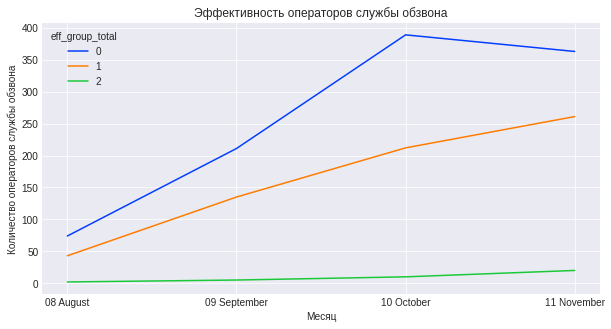

In [83]:
with plt.style.context('seaborn-darkgrid'):
    plt.figure(figsize=(10,5))
    ax = sns.lineplot(data = eff_pivot_out, hue = 'eff_group_total', y = 'operator_id', x = 'month', palette='bright')
    plt.title('Эффективность операторов службы обзвона')
    plt.xlabel('Месяц')
    plt.ylabel('Количество операторов службы обзвона')
    plt.show()

Добавим номер колл-центра к данным по эффективности для итогового анализа.

In [84]:
user_pivot_out = data_out.pivot_table(index = ['operator_id', 'user_id'], values = 'date', aggfunc = 'count').reset_index()

In [85]:
eff_metrics_out_final = eff_metrics_out_final.merge(user_pivot_out[['user_id', 'operator_id']], on = 'operator_id', how = 'left')

In [86]:
eff_metrics_out_final.head()

,operator_id,month,call_duration_rank,calls_count_rank,eff_group_total,user_id
0,879896,08 August,0,1,0,166406
1,879896,09 September,0,1,0,166406
2,879896,10 October,1,1,1,166406
3,879896,11 November,1,1,1,166406
4,879898,08 August,0,2,0,166406


## Итог: функция оценки динамики эффективности оператора обзвона <a id="eff_out"></a>

Воспользуемся написанной ранее функцией для подсчета эффективности операторов определенного колл-центра.

В качестве примера возьмем тот же номер колл-центра, что и в предыдущем случае. Обнаружим, что в нем работают операторы обоих направлений.

Напоминалка: для того, чтобы выбрать всех клиентов, нужно вместо конкретного номера ввести "0". То же касается для выбора всех операторов конкретного клиента.

In [87]:
user_eff(eff_metrics_out_final, 166406, 0)

,operator_id,month,call_duration_rank,calls_count_rank,eff_group_total,user_id
0,879896,08 August,0,1,0,166406
1,879896,09 September,0,1,0,166406
2,879896,10 October,1,1,1,166406
3,879896,11 November,1,1,1,166406
4,879898,08 August,0,2,0,166406
5,879898,09 September,0,2,0,166406
6,879898,10 October,0,2,0,166406
7,879898,11 November,0,2,0,166406
23,880240,08 August,0,1,0,166406


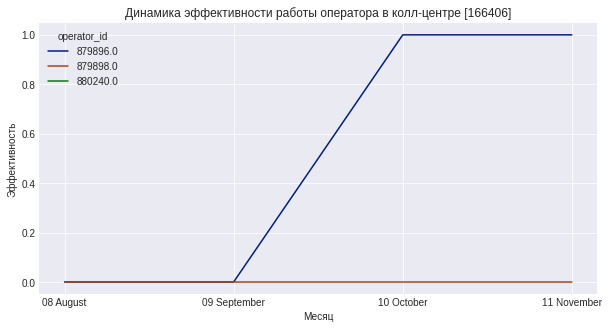

In [88]:
with plt.style.context('seaborn-darkgrid'):
    plt.figure(figsize=(10,5))
    sns.lineplot(data = user_eff(eff_metrics_out_final, 166406, 0), x = 'month', y = 'eff_group_total', hue = 'operator_id', palette = 'dark')
    plt.title('Динамика эффективности работы оператора в колл-центре {}'.format(user_eff(eff_metrics_in_final, 166406, 0)['user_id'].unique()))
    plt.xlabel('Месяц')
    plt.ylabel('Эффективность')
    plt.show()

## Сводная эффективность <a id="total"></a>

Объединим полученные результаты в одну таблицу и сделаем свод по эффективности.

In [89]:
eff_metrics_in_final.insert(2, "direction", 'in')
eff_metrics_out_final.insert(2, "direction", 'out')

In [90]:
eff_metrics_in_final.head()

,operator_id,month,direction,part_missed_calls_rank,waiting_time_rank,eff_group_total,user_id
0,879896,08 August,in,2,1,1,166406
1,879896,09 September,in,2,1,1,166406
2,879896,10 October,in,2,1,1,166406
3,879898,08 August,in,2,1,1,166406
4,879898,09 September,in,2,1,1,166406


In [91]:
eff_metrics_final = pd.concat([eff_metrics_in_final[['operator_id', 'month', 'direction', 'eff_group_total', 'user_id']], eff_metrics_out_final[['operator_id', 'month', 'direction', 'eff_group_total', 'user_id']]], ignore_index=True)

Проверим работу функции фильтра эффективности на объединенных данных.

In [92]:
user_eff(eff_metrics_final, 166406, 0)

,operator_id,month,direction,eff_group_total,user_id
0,879896,08 August,in,1,166406
1,879896,09 September,in,1,166406
2,879896,10 October,in,1,166406
3,879898,08 August,in,1,166406
4,879898,09 September,in,1,166406
5,879898,10 October,in,1,166406
6,879898,11 November,in,2,166406
1468,166406_0,08 August,in,0,166406
1469,166406_0,09 September,in,0,166406
1470,166406_0,10 October,in,0,166406


Графики также можно вывести рядом. Теперь мы видим помесячную динамику эффективности каждого оператора в разбивке по его специализации.

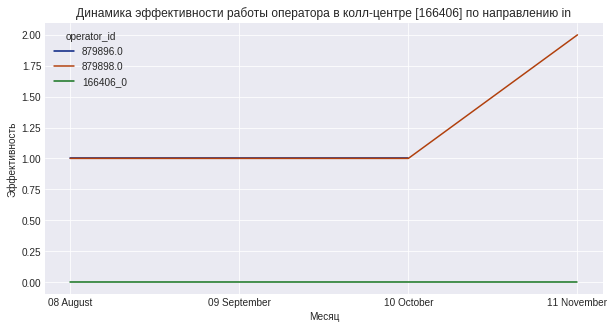

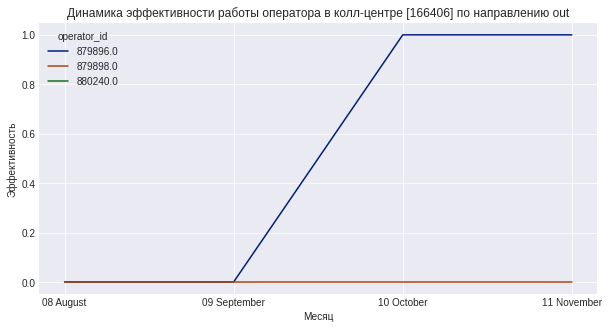

In [93]:
for i in user_eff(eff_metrics_final, 166406, 0)['direction'].unique():
    with plt.style.context('seaborn-darkgrid'):
        plt.figure(figsize=(10,5))
        sns.lineplot(data = user_eff(eff_metrics_final, 166406, 0).query('direction == @i'), x = 'month', y = 'eff_group_total', hue = 'operator_id', palette = 'dark')
        plt.title('Динамика эффективности работы оператора в колл-центре {} по направлению {}'.format(user_eff(eff_metrics_in_final, 166406, 0)['user_id'].unique(), i))
        plt.xlabel('Месяц')
        plt.ylabel('Эффективность')
        plt.show()

Важный момент: так как большинство операторов в колл-центрах занимаются и входящими, и исходящими звонками, объективнее будет оценивать их работу по каждой специализации в отдельности.

In [94]:
for i in eff_metrics_final['direction'].unique():
    print('Количество колл-центров, где есть хотя бы один неэффективный оператор по направлению {}: {}.'.format(i, eff_metrics_final.query('eff_group_total == 0').query('direction == @i')['user_id'].nunique()))
for i in eff_metrics_final['direction'].unique():
    print('Количество неэффективных операторов по направлению {}: {}  из {}.'.format(i, eff_metrics_final.query('eff_group_total == 0').query('direction == @i')['operator_id'].nunique(), data.query('direction == @i')['operator_id'].nunique()))   

Количество колл-центров, где есть хотя бы один неэффективный оператор по направлению in: 302.
Количество колл-центров, где есть хотя бы один неэффективный оператор по направлению out: 202.
Количество неэффективных операторов по направлению in: 752  из 1058.
Количество неэффективных операторов по направлению out: 691  из 932.


Из 307 клиентов 302 имеют хотя бы одного неэффективного оператора поддержки. Мы задали достаточно жёсткие, но объективные  условия эффективности по времени ожидания. 

202 клиента из 307 также имеют неэффективных операторов обзвона.

In [95]:
#создаем список уникальных номеров клиента, неэффективных по поддержке
users_in_unique = eff_metrics_final.query('eff_group_total == 0').query('direction == "in"')['user_id'].unique()
#проверяем, сколько этих номеров встречается среди неэффективных по обзвону
print('Количество колл-центров, где есть неэффективные операторы по каждому направлению: ', eff_metrics_final.query('eff_group_total == 0').query('direction == "out"').query('user_id in @users_in_unique')['user_id'].nunique())

Количество колл-центров, где есть неэффективные операторы по каждому направлению:  200


In [96]:
#Делим полученное ячейкой выше значение на общее количество колл-центров
print('Доля колл-центров, где есть неэффективные операторы по двум направлениям: {:.2%}.'.format(eff_metrics_final.query('eff_group_total == 0').query('direction == "out"').query('user_id in @users_in_unique')['user_id'].nunique()/data['user_id'].nunique()))

Доля колл-центров, где есть неэффективные операторы по двум направлениям: 65.36%.


Наше исследование показало, что **65,36%** клиентов имеют хотя бы одного неэффективного сотрудника в какой-либо месяц рассматриваемого периода.

С помощью функции `eff_group` можно посмотреть динамику эффективности сотрудников каждого клиента.

Нужно выяснить возможные причины:
* В случае с операторами поддержки это может быть нехватка работников в пиковые часы (для подтверждения этой гипотезы нужны данные по загрузке в течение суток);
* В случае с операторами службы обзвона нужно убедиться в корректности базы абонентов и исключить проблемы со связью (много звонков нулевой и близкой к нулевой длительности). Следующий шаг - дополнительный инструктаж работников для совершенствования навыка успешных переговоров;
* Обязательно нужно проверить причины, по которым звонок не дошел до оператора - такие строки помечены в отчете номером клиента с индексом 0.

### Сервис по отслеживанию неэффективных операторов может быть востребован среди наших клиентов, а нам он может быть интересен, так как количество клиентов растет и имеется тенденция к увеличению числа сотрудников в них.

## Проверка гипотез <a id="hypothesis"></a>

### Задача: проверить нулевую гипотезу о том, что время ожидания ответа зависит от тарифного плана, к которому подключен клиент. <a id="tariff"></a>

In [97]:
#Добавляем столбец с тарифом к финальной таблице
data_final = data.merge(clients, on = 'user_id', how = 'left')

In [98]:
#data_final.head()

In [99]:
data_final.pivot_table(index = 'tariff_plan', values = 'waiting_time', aggfunc = {'count', 'mean', 'median', 'std'})

,count,mean,median,std
tariff_plan,,,,
A,13530.0,599.749667,75.0,1926.652156
B,17199.0,162.812082,52.0,330.588853
C,18162.0,182.097456,49.0,700.561112


Тарифом А пользуются реже, чем В и С. Средняя и медиана (как и стандартное отклонение) ожидания ответа по этому тарифу выше, чем по двум остальным. 

Тарифы В и С имеют схожие характеристики.

Предварительно можно ожидать, что гипотеза Н0 подтвердится в отношении В и С, но будет отвергнута при сравнении А и С, В и С.

Построим распределения времени ожидания в зависимости от тарифа (ось Х ограничим для читаемости графика).

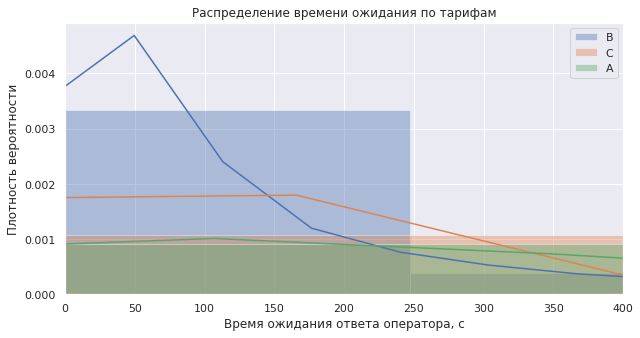

In [100]:
sns.set()
fig, ax = plt.subplots(figsize=(10,5))
for tariff in data_final['tariff_plan'].unique():
  ax = sns.distplot(data_final.query('tariff_plan == @tariff')['waiting_time'], label = tariff)
ax.set(title = "Распределение времени ожидания по тарифам",
      xlabel = "Время ожидания ответа оператора, с",
      ylabel = "Плотность вероятности",
      xlim = (0,400))      
ax.legend()
plt.show()

График распределения имеет экспоненциальный вид, длинный "хвост" вправо указывает на большое разнообразие значений даже после обработки выбросов. 

Проведем попарное сравнение трех выборок, предварив его тестом Левене на равенство дисперсий (для уточнения параметров статтеста). Для корректировки уровня значимости вводим поправку Бонферрони на множественные проверки.

In [101]:
a = data_final.query('tariff_plan =="A"')['waiting_time']
b = data_final.query('tariff_plan =="B"')['waiting_time']
c = data_final.query('tariff_plan =="C"')['waiting_time']

alpha = 0.05/3
stat, p = levene(a, b)
print(p)
if (p < alpha):
    print("Отвергаем нулевую гипотезу равенства дисперсий между A и B")
else:
    print("Не получилось отвергнуть нулевую гипотезу между A и B")

stat, p = levene(a, c)
print(p)
if (p < alpha):
    print("Отвергаем нулевую гипотезу равенства дисперсий между A и C")
else:
    print("Не получилось отвергнуть нулевую гипотезу между A и C")

stat, p = levene(b, c)
print(p)
if (p < alpha):
    print("Отвергаем нулевую гипотезу равенства дисперсий между B и C")
else:
    print("Не получилось отвергнуть нулевую гипотезу между B и C")

6.766988757721232e-183
Отвергаем нулевую гипотезу равенства дисперсий между A и B
1.5727038116159457e-154
Отвергаем нулевую гипотезу равенства дисперсий между A и C
0.0003139352689704977
Отвергаем нулевую гипотезу равенства дисперсий между B и C


Дисперсии трех групп различаются. Учтем это при проверке статзначимости различий (t-test).

In [102]:
alpha = 0.05
results = st.ttest_ind(a, b, equal_var = False)
print('p-значение:', results.pvalue)
 
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 1.7650536514315934e-146
Отвергаем нулевую гипотезу


Нельзя утверждать, что время ожидания по тарифам А и В одинаково. Принимаем альтернативную гипотезу - они различаются.

In [103]:
alpha = 0.05/3
results = st.ttest_ind(a, c, equal_var = False)
print('p-значение:', results.pvalue)
 
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 1.0878770451964446e-125
Отвергаем нулевую гипотезу


Такой же вывод при сравнении статзначимости различий времени ожидания по группам А и С.

In [104]:
alpha = 0.05/3
results = st.ttest_ind(b, c, equal_var = False)
print('p-значение:', results.pvalue)
 
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.0008445998404941911
Отвергаем нулевую гипотезу


Нельзя отвергнуть нулевую гипотезу о одинаковом среднем времени ожидания по тарифам В и С. Такой вывод мы и предполагали с самого начала.

### Задача: проверить нулевую гипотезу о том, что длительность звонков, которые осуществляют операторы обзвона, не зависит от количества звонков <a id="size"></a>

In [105]:
#Сводная таблица по медианной длительности переговоров
median_duration_pivot = data_out.query('call_duration != 0').pivot_table(index = 'user_id', values = ['call_duration', 'calls_count'], aggfunc = 'median').sort_values(by = 'call_duration', ascending = False).reset_index()
#Разбиваем данные на три равные по количеству клиентов группы. Критерий - средняя продолжительность переговоров
cut_labels = ['Короткие переговоры', 'Средняя длительность переговоров', 'Долгие переговоры']
median_duration_pivot['call_duration_group'] = pd.qcut(median_duration_pivot['call_duration'], 3, labels = cut_labels)
#Смотрим среднюю длительность разговора по группам
duration_grouped = median_duration_pivot.pivot_table(index = 'call_duration_group', values = ['call_duration', 'calls_count'], aggfunc = 'median')
duration_grouped

,call_duration,calls_count
call_duration_group,,
Короткие переговоры,66.00,1.00
Средняя длительность переговоров,302.75,3.25
Долгие переговоры,1248.75,12.75


Предварительно можно сказать, что зависимость абсолбтно нелогичная - медианное число коротких переговоров меньше, чем у долгих.

Проведем статистические тесты, учитывая тест на разницу дисперсий Левене и поправку на множественные сравнения Бонферрони.

In [106]:
short = median_duration_pivot.query('call_duration_group == "Короткие переговоры"')['calls_count']
medium = median_duration_pivot.query('call_duration_group == "Средняя длительность переговоров"')['calls_count']
long = median_duration_pivot.query('call_duration_group == "Долгие переговоры"')['calls_count']

alpha = 0.05/3
stat, p = levene(short, medium)
print(p)
if (p < alpha):
    print("Отвергаем нулевую гипотезу равенства дисперсий между количеством звонков с короткими и средними переговорами")
else:
    print("Не получилось отвергнуть нулевую гипотезу между количеством звонков с короткими и средними переговорами")

stat, p = levene(short, long)
print(p)
if (p < alpha):
    print("Отвергаем нулевую гипотезу равенства дисперсий между количеством звонков с короткими и длинными переговорами")
else:
    print("Не получилось отвергнуть нулевую гипотезу между количеством звонков с короткими и длинными переговорами")

stat, p = levene(medium, long)
print(p)
if (p < alpha):
    print("Отвергаем нулевую гипотезу равенства дисперсий между количеством звонков со средними и длинными переговорами")
else:
    print("Не получилось отвергнуть нулевую гипотезу между количеством звонков со средними и длинными переговорами")

1.1739715602717976e-05
Отвергаем нулевую гипотезу равенства дисперсий между количеством звонков с короткими и средними переговорами
2.1794718225302753e-15
Отвергаем нулевую гипотезу равенства дисперсий между количеством звонков с короткими и длинными переговорами
9.050775345314837e-09
Отвергаем нулевую гипотезу равенства дисперсий между количеством звонков со средними и длинными переговорами


Статистически доказали неравенство дисперсий на выборках. Переходим к анализу значимости различий (t-test).

In [107]:
alpha = 0.05/3
results = st.ttest_ind(short, medium, equal_var = False)
print('p-значение:', results.pvalue)
 
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 1.402714209231313e-09
Отвергаем нулевую гипотезу


In [108]:
alpha = 0.05/3
results = st.ttest_ind(short, long, equal_var = False)
print('p-значение:', results.pvalue)
 
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 1.438586025500427e-18
Отвергаем нулевую гипотезу


In [109]:
alpha = 0.05/3
results = st.ttest_ind(long, medium, equal_var = False)
print('p-значение:', results.pvalue)
 
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 9.74309064856352e-14
Отвергаем нулевую гипотезу


Статистический анализ показал, что нулевую гипотезу о зависимости количества звонков от длительности разговора нужно отвергнуть. Принимаем альтернативную гипотезу: эти показатели не имеют прямой зависимости.


## Выводы <a id="conclusions"></a>

Мы проанализировали данные о качестве и количестве звонков наших клиентов в динамике по месяцам. Важные моменты:

* Проведена очистка исходного датасета от пропусков и дубликатов. Аномальные значения были убраны для каждого из направлений работы оператора отдельно;
* В данных много строк с пропущенным идентификатором оператора. Мы заменили их на номер колл-центра с индексом 0;
* Эффективность операторов мы считали в привязке к их специализации (поддержка или обзвон). Один и тот же оператор колл-центра может быть эффективен на обзвоне и не эффективен на поддержке ( и наоборот).

Итоги:

* Создана функция, которая показывает статистику неэффективных сотрудников в динамике по месяцам;
* Количество неэффективных операторов по направлению in: 752  из 1058. Мы поставили жёсткие, но объективные критерии;
* Количество неэффективных операторов по направлению out: 691  из 932;
* **Работу 65% (202 из 307) клиентов можно оптимизировать** по обоим направлениям. 
* Необходимо выяснить причины неэффективности для дальнейшей работы над ее снижением. Для поддержки - **анализ пиковой суточной нагрузки, для обзвона - корректность базы, техническая исправность системы**. Для всех направлений - **компетентность сотрудников**;
* Статистически среднее время ожидания ответа оператора отличается для разных тарифных планов: в тарифе А и среднее, и медианное время больше, чем в В и С. При этом В и С похожи по этому показателю. Отдельно **следует проанализировать рациональность перевода части клиентов на другой тариф**;
* Среднее время разговора и количество звонков для операторов обзвона не имеют обратной корреляции. Нужно понять причину, почему с уменьшением длительности переговоров не увеличивается количество исходящих.

Общий вывод  - **сервис по определению эффективности операторов однозначно будет востребован** на данном этапе. 



## Презентация <a id="presentation"></a>

Основные тезисы этой работы можно увидеть в приложенной презентации.

Презентация: <https://drive.google.com/file/d/1d9paRnmB_re4QWj4n9ZWtG_UilrgGydy/view?usp=sharing>

## Дашборд  <a id="dash"></a>

Ссылка на интерактивный отчет: <https://public.tableau.com/views/_16256948679410/Dashboard1?:language=en-US&:display_count=n&:origin=viz_share_link>